In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(accuracy_score(Y1, guesses1))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(accuracy_score(Y2, guesses2))

1.0
0.5


Let's set Rain = 1 & Sun = 0

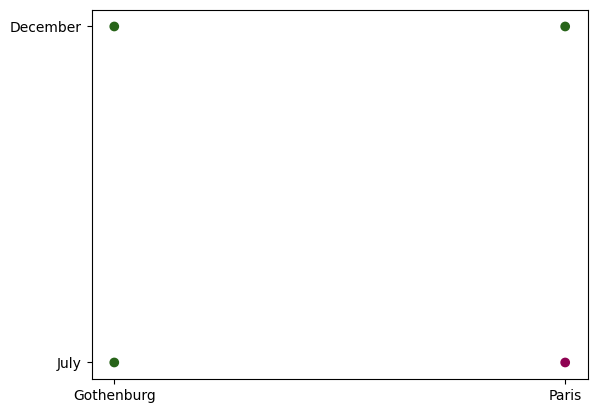

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
GP = pd.DataFrame([['Gothenburg', 'July', 1], 
                   ['Gothenburg', 'December', 1], 
                   ['Paris', 'July', 0], 
                   ['Paris', 'December', 1]],
                columns = ['City', 'Month', 'Weather'])
plt.scatter(GP['City'], GP['Month'], c = GP['Weather'], cmap = 'PiYG');

As shown as in the graph above, the data of Gothenburg and Paris weather is linear separable, then the model perceptron find a separating line in the graph which helps the model a perfect classification

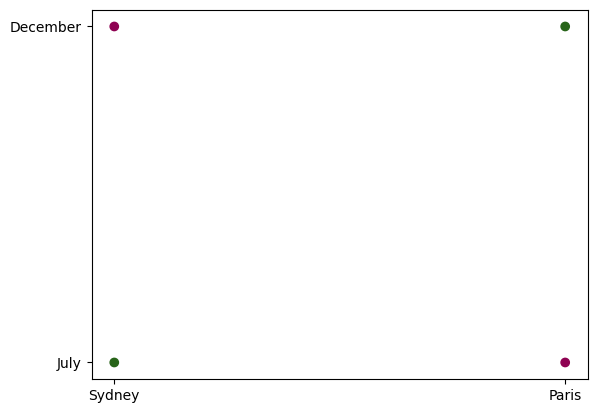

In [3]:
SP = pd.DataFrame([['Sydney', 'July', 1], 
                   ['Sydney', 'December', 0], 
                   ['Paris', 'July', 0], 
                   ['Paris', 'December', 1]],
                columns = ['City', 'Month', 'Weather'])
plt.scatter(SP['City'], SP['Month'], c = SP['Weather'], cmap = 'PiYG');

It is impossible in this case if we want to have a linear separator line to distinguish between the rain weather and sun weather. That is why they cannot be solved using a linear decision boundary

# Linear Classifiers implementation

In [8]:
import pandas as pd 
import numpy as np
import random
from sklearn.base import BaseEstimator
from numpy import linalg as LA
import matplotlib.pyplot as plt

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from aml_perceptron import Perceptron, SparsePerceptron
import scipy.linalg.blas as blas

In [9]:
class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])

# Implementing the SVC

In [10]:
class SVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=7000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
    
        # convert the data to a list of tuples of (features, label)
        data = list(zip(X, Ye))
        
        # create a random subset of indices of the data to be looped on,
        # and avoid looping over the while dataset
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        # initialize empty lists to add in the hingeloss and 
        # the score while looping over the rows of the data subset
        hingeLoss=[]
        scoreList=[]
        
        for i in range (self.n_iter):
            
            # increment the value t by 1
            t = i+1
            
            # assign the features of the row to x and the corresponding label to y
            x= data[T[i]][0]
            y = data[T[i]][1]
            
            # calculate the value of the learning rate eta
            eta = 1/(self.Lambda*t)
            
            # calculate the score
            score = x.dot(self.w)
            
            # case when y*score is less than oner
            if y*(score) <1:
                self.w = (1-eta*self.Lambda)*self.w + eta*y*x
                hingeLoss.append(1-y*score)
                
            else:
                self.w = (1-eta*self.Lambda)*self.w
                hingeLoss.append(0)
            
            #print the objective function value every 500 epochs
            if i%500==0 and i != 0:
                # print objective function at epoch i as 
                # average of hinge loss at 
                #i + the regularization paramete lambda/2*||w||^2
                print( "The objective function at epoch " +
                      str(i)+': '+str(np.mean(hingeLoss)+(self.Lambda/2)*(self.w.dot(self.w))))
                    
                    
            scoreList.append(y*score)

In [11]:
# This function reads the corpus, 
#returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


if __name__ == '__main__':
    
    # Read all the documents.
    X, Y = read_data('data/all_sentiment_shuffled.txt')
    
    # Split into training and test parts.
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,random_state=0)

# function to calculate the training time and accuracy of the model    
def model_report(pipeline, s):
    # Train the classifier.
    t0 = time.time()
    pipeline.fit(Xtrain, Ytrain)
    t1 = time.time()
    print('\n')
    print('Training time of '+s+' algorithm: {:.2f} sec.'.format(t1-t0))

    # Evaluate on the test set.
    Yguess = pipeline.predict(Xtest)
    print('Accuracy of '+s+' algorithm: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))



# Set up the preprocessing steps for the SVC model
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVC()
)

model_report(pipeline,'SVC')

The objective function at epoch 500: 1.9254888094438747
The objective function at epoch 1000: 1.2786878843036857
The objective function at epoch 1500: 1.0503559609981337
The objective function at epoch 2000: 0.9351942773079976
The objective function at epoch 2500: 0.8686715113228143
The objective function at epoch 3000: 0.8268895408990294
The objective function at epoch 3500: 0.7901546478485718
The objective function at epoch 4000: 0.7620451704430027
The objective function at epoch 4500: 0.7387961811231303
The objective function at epoch 5000: 0.7213188817418943
The objective function at epoch 5500: 0.705969875756209
The objective function at epoch 6000: 0.691265741086569
The objective function at epoch 6500: 0.6821842086224562


Training time of SVC algorithm: 0.77 sec.
Accuracy of SVC algorithm: 0.8086.


# Logistic Regression

In [12]:
class LogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=7000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        loss = []
        scoreList=[]
        
        for i in range (self.n_iter):
            
            t = i+1
            
            x= data[T[i]][0]
            y = data[T[i]][1]
            
            eta = 1/(self.Lambda*t)
            
            score = x.dot(self.w)
            
            # compute gradient of the loss function
            gradLoss = -y/(1+np.exp(y*score))*x
            
            # compute gradient of f(w,x,y)
            gradientF = self.Lambda*self.w + gradLoss
            
            # update w = w- eta* gradient
            self.w = self.w - eta*gradientF
            
            scoreList.append(y*score)
      
            loss.append(np.log(1+np.exp(-y*score)))
            
            if i%500==0 and i != 0:
                # print objective function at epoch i as 
                # average of hinge loss at i + the regularization paramete lambda/2*||w||^2
                print( "The objective function at epoch " +str(i)+': '+str(np.mean(loss)+(self.Lambda/2)*(self.w.dot(self.w))))

In [13]:
# Set up the preprocessing steps for the logistic regression model.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(), 
    LogisticRegression()
)

model_report(pipeline,'Logistic Regression')

The objective function at epoch 500: 1.390864428637927
The objective function at epoch 1000: 0.9695656855226077
The objective function at epoch 1500: 0.8286751085420255
The objective function at epoch 2000: 0.7609711113830778
The objective function at epoch 2500: 0.7196386692042728
The objective function at epoch 3000: 0.6929209469992705
The objective function at epoch 3500: 0.671342861901071
The objective function at epoch 4000: 0.6568716001565752
The objective function at epoch 4500: 0.6442535806055834
The objective function at epoch 5000: 0.6345556751983958
The objective function at epoch 5500: 0.6260655724011355
The objective function at epoch 6000: 0.6198868659157959
The objective function at epoch 6500: 0.6137137040981329


Training time of Logistic Regression algorithm: 0.72 sec.
Accuracy of Logistic Regression algorithm: 0.8061.


# Making your code more efficient

###  Faster linear algebra operations

### Implementing the SVC algorithm with blas functions

In [14]:
class BlasSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=7000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        hingeLoss=[]
        scoreList=[]
        
        for i in range (self.n_iter):
            
            t = i+1
            
            x= data[T[i]][0]
            y = data[T[i]][1]
            
            eta = 1/(self.Lambda*t)
            
            # computing the score x.w
            score = blas.ddot(x,self.w)
            
            #y.(x.w)
            Yscore = blas.ddot(y,score)
            
            if Yscore <1:
                self.w = blas.dscal((1-eta*self.Lambda),self.w) + eta*y*x
                
            else:
                blas.dscal((1-eta*self.Lambda),self.w)

In [15]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    BlasSVC()
)

model_report(pipeline,'Blas SVC')



Training time of Blas SVC algorithm: 0.71 sec.
Accuracy of Blas SVC algorithm: 0.8204.


Using blas functions for the SVC model implementation, the model achieved approximately the same accuracy as the first implementation of the model using numpy function in 87% of the time.

In [16]:
class BlasLogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=7000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        loss = []
        scoreList=[]
        
        for i in range (self.n_iter):
            
            t = i+1
            
            x= data[T[i]][0]
            y = data[T[i]][1]
            
            eta = 1/(self.Lambda*t)
            
            # computing the score x.w
            score = blas.ddot(x,self.w)
            
            # compute gradient of the loss function
            gradLoss = -1/(1+np.exp(blas.ddot(y,score)))*blas.dscal(y,x)
            
            # compute gradient of f(w,x,y)
            gradientF = self.Lambda*self.w + gradLoss
            
            # update w = w- eta* gradient
            self.w = self.w - blas.dscal(eta,gradientF)


In [17]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(), 
    BlasLogisticRegression()
)

model_report(pipeline,'Blas Logistic Regression')



Training time of Blas Logistic Regression algorithm: 0.68 sec.
Accuracy of Blas Logistic Regression algorithm: 0.7969.


Using blas functions for the Logistic Regression model implementation, the model achieved approximately the same accuracy as the first implementation of the model using numpy function in 80% of the time.

###  Using sparse vectors

#### The feature selector function SelectKbest removal

In [18]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(), 
    SVC()
)

model_report(pipeline,'SVC')

The objective function at epoch 500: 1.6747010107038456
The objective function at epoch 1000: 1.222654705920315
The objective function at epoch 1500: 1.086507442057922
The objective function at epoch 2000: 0.9975119962701016
The objective function at epoch 2500: 0.9322481824041153
The objective function at epoch 3000: 0.899249485785867
The objective function at epoch 3500: 0.8773120978682053
The objective function at epoch 4000: 0.8605051487700659
The objective function at epoch 4500: 0.8458236022363974
The objective function at epoch 5000: 0.8327919397361283
The objective function at epoch 5500: 0.8211353428356848
The objective function at epoch 6000: 0.8119485434796283
The objective function at epoch 6500: 0.8046641589800094


Training time of SVC algorithm: 3.10 sec.
Accuracy of SVC algorithm: 0.8057.


In [19]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(), 
    LogisticRegression()
)
model_report(pipeline,' Logistic Regression')

The objective function at epoch 500: 1.0918368608929838
The objective function at epoch 1000: 0.8513218687828119
The objective function at epoch 1500: 0.772799395317524
The objective function at epoch 2000: 0.7334819001798594
The objective function at epoch 2500: 0.7109822622034723
The objective function at epoch 3000: 0.6958697549466162
The objective function at epoch 3500: 0.6852888937240955
The objective function at epoch 4000: 0.6769912248103025
The objective function at epoch 4500: 0.6709062623488555
The objective function at epoch 5000: 0.6656028576888791
The objective function at epoch 5500: 0.6615545053949033
The objective function at epoch 6000: 0.6580618610720865
The objective function at epoch 6500: 0.6551048542204071


Training time of  Logistic Regression algorithm: 3.38 sec.
Accuracy of  Logistic Regression algorithm: 0.7931.


By removing the feature selection function SelectKbest from the models training pipeline, we noticed that the models achieved approximately the same accuracy as when the function was included in the pipeline, which may mean that all the features (terms) are important for the model classification task performance, while the training time for each of both models (SVC and Logistic Regression) increase by approximately 4-5 times.

### Training time and accuracy differences by adding both of the bigrams and unigrams to the tfidf vectorizer

In [20]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(), 
    SVC()
)

model_report(pipeline,'SVC')

The objective function at epoch 500: 1.774479159169175
The objective function at epoch 1000: 1.3037884653763112
The objective function at epoch 1500: 1.140017348782562
The objective function at epoch 2000: 1.064958432236218
The objective function at epoch 2500: 1.026063404147051
The objective function at epoch 3000: 0.9958784340686342
The objective function at epoch 3500: 0.9745859670461097
The objective function at epoch 4000: 0.9590656288254263
The objective function at epoch 4500: 0.945564751216215
The objective function at epoch 5000: 0.9357361188723795
The objective function at epoch 5500: 0.9261492339213078
The objective function at epoch 6000: 0.9192852258447665
The objective function at epoch 6500: 0.9138355207603971


Training time of SVC algorithm: 22.57 sec.
Accuracy of SVC algorithm: 0.8107.


In [21]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(), 
    LogisticRegression()
)

model_report(pipeline,'Logistic Regression')

The objective function at epoch 500: 0.9462394216646365
The objective function at epoch 1000: 0.8001463924944586
The objective function at epoch 1500: 0.7500899864456722
The objective function at epoch 2000: 0.7250404385697481
The objective function at epoch 2500: 0.7106735598132147
The objective function at epoch 3000: 0.7012140623143618
The objective function at epoch 3500: 0.6946064041110188
The objective function at epoch 4000: 0.6897574762324211
The objective function at epoch 4500: 0.6859267421288238
The objective function at epoch 5000: 0.6828613474184622
The objective function at epoch 5500: 0.6802356459870781
The objective function at epoch 6000: 0.6780515120682501
The objective function at epoch 6500: 0.6762835301957667


Training time of Logistic Regression algorithm: 25.49 sec.
Accuracy of Logistic Regression algorithm: 0.8112.


By specifying the unigrams and bigrams calculation in the TfIdf vectorization step in both of the models pipelines, the accuracies of each of the models stayed approximately the same, while the training time increased drastically for SVC from 3.4 secs to 24 secs and for Logistic Regression from 3.8 secs to 28 secs, and that's because now the model is trained using a much higher number of features as the pair combination between the terms of the text is now taken into consideration by the model in the training phase.

### Using sparse functions

# Sparse SVC

In [22]:
### Sparse and dense vectors don't collaborate very well in NumPy/SciPy.
### Here are two utility functions that help us carry out some vector
### operations that we'll need.

def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return np.dot(w[x.indices], x.data)




In [23]:
class SparseSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm,
    assuming that the input feature matrix X is sparse.
    """

    def __init__(self, n_iter=1000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        subData = [data[i] for i in T]

        for i in range(self.n_iter):
            for x, y in subData:
                
                t = i+1

                eta = 1/(self.Lambda*t)

                score = sparse_dense_dot(x,self.w)

                Yscore = y*score

                if Yscore <1:
                    add_sparse_to_dense(x, self.w, y/self.Lambda)
                    self.w = self.w - eta*self.Lambda*self.w
                else:
                    w = (1-eta*self.Lambda)*self.w
                    
                    

In [24]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    Normalizer(),
    SelectKBest(k=1000),
    SparseSVC()
)

model_report(pipeline,'Sparse SVC')



Training time of Sparse SVC algorithm: 7.59 sec.
Accuracy of Sparse SVC algorithm: 0.7339.


using sparse vectors for the mathematical operations included in the SVC model implementation, the model performed quite poorley where it finished the training phase in approximately 9 seconds and with a lower accuracy of approximately 4% than the numpy implementation of the model.

# Sparse LogisticRegression

In [25]:
class SparseLogisticR(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=1000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        subData = [data[i] for i in T]
        
        t=0
        
        for i in range(self.n_iter):
            
            for x, y in subData:
                
                t=t+1
                
                eta=1/(self.Lambda*t)
                w=1-eta*self.Lambda*self.w             
                add_sparse_to_dense(x , self.w,
                                    y*eta/(1 + np.exp(y*(sparse_dense_dot(x, self.w)))))

In [26]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(), 
    SparseLogisticR()
)

model_report(pipeline,'Sparse Logistic Regression')



Training time of Sparse Logistic Regression algorithm: 15.73 sec.
Accuracy of Sparse Logistic Regression algorithm: 0.6861.


using sparse vectors for the mathematical operations included in the logistic regression model implementation, the model performed quite poorley where it finished the training phase in approximately 17 seconds and with a lower accuracy of approximately 10% than the numpy implementation of the model.

### (c) Speeding up the scaling operation

In [27]:
class SparseLogisticRc(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=1000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        subData = [data[i] for i in T]
        
        t=0
        
        #initializing the scaling factor a 
        a = 1
        
        for i in range(self.n_iter):
            
            for x, y in subData:
                
                t=t+1
                
                eta=1/(self.Lambda*t)
                
                #replacing the vector scaling step
                a = (1- eta*self.Lambda)*a
                
                #  division by zero exception, so we added an if statement to
                # handle this case by removing the scaling factor if its equal to zero
                if a == 0:
                    w=1-eta*self.Lambda*self.w             
                    add_sparse_to_dense(x , self.w, y*eta/(1 + np.exp(y*(sparse_dense_dot(x, self.w)))))  
                    
                else:
                    add_sparse_to_dense(x , self.w, y*eta/(a*(1 + np.exp(y*(sparse_dense_dot(x, self.w))))))
                    self.w *=a
                
    

In [28]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(), 
    SparseLogisticRc()
)

model_report(pipeline,'Sparse Logistic Regression')



Training time of Sparse Logistic Regression algorithm: 15.88 sec.
Accuracy of Sparse Logistic Regression algorithm: 0.6924.


using the scaling factor <b>a</b> the model showed approximately no improvement than the model implementation using sparse vectors, so we investigate further the effect of replacing the other scaling operations with blas functions

### Using blas functions for scaling and sparse vectors for other operations:

In [29]:
class SparseLogisticRc2(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=1000,Lambda=0.001,eta=0.001):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.Lambda = Lambda
        self.eta = eta
    

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        
        n_instances = X.shape[0]
        
        self.w = np.zeros(n_features)
        
        data = list(zip(X, Ye))
        
        T = np.random.choice(len(data),self.n_iter,replace = False)
        
        subData = [data[i] for i in T]
        
        t=0
        
        a = 1
        
        for i in range(self.n_iter):
            
            for x, y in subData:
                
                t=t+1
                
                eta=1/(self.Lambda*t)
                
                a = (1- eta*self.Lambda)*a
                
                #  division by zero exception, so we added an if statement to
                # handle this case
                if a == 0:
                    blas.dscal(1-eta*self.Lambda,self.w)             
                    add_sparse_to_dense(x , self.w, y*eta/(1 + np.exp(y*(sparse_dense_dot(x, self.w)))))  
                    
                else:
                    add_sparse_to_dense(x , self.w, y*eta/(a*(1 + np.exp(y*(sparse_dense_dot(x, self.w))))))
                    blas.dscal(a,self.w)
                
    



In [30]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(), 
    SparseLogisticRc2(n_iter=1000,Lambda=0.001,eta=0.001)
)

model_report(pipeline,'Sparse Logistic Regression with blas scaling functions')



Training time of Sparse Logistic Regression with blas scaling functions algorithm: 12.82 sec.
Accuracy of Sparse Logistic Regression with blas scaling functions algorithm: 0.7919.


by replacing the vector scaling operations with blas functions in the sparse Logistic Regression model, the model trainging time decreased slightly with 2 seconds, while the model's accuracy increased by approximately 12%